In [1]:
# !curl https://www.nuscenes.org/data/v1.0-mini.tgz -o v1.0-mini.tgz # Download the nuScenes mini split.
# !tar -xf v1.0-mini.tgz

# !pip3 install nuscenes-devkit &> /dev/null  # Install nuScenes.

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from PIL import Image
import torch.nn.functional as F
from IPython.display import Image as IPImage
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
from nuscenes.nuscenes import NuScenes
PATH = '/Users/labuser/Downloads'

nusc = NuScenes(version='v1.0-mini', dataroot=PATH, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.316 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
nusc.sample[0]

NameError: name 'nusc' is not defined

In [4]:
class NuScenesSceneCamFront(Dataset):
    def __init__(self, nusc, length, width):
        self.nusc = nusc
        self.samples = []

        self.length = length
        self.width = width

        for sample in nusc.sample:
            sensor_type = "CAM_FRONT"
            cam_front_data = nusc.get("sample_data", sample["data"][sensor_type])
            cam_front_data_path = os.path.join(PATH, cam_front_data["filename"])
            self.samples.append(cam_front_data_path)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = Image.open(self.samples[idx])
        # Convert to grayscale
        sample = sample.convert('L')
        sample = sample.resize((self.width, self.length))
        sample = transforms.ToTensor()(sample)

        return sample

NameError: name 'Dataset' is not defined

In [5]:
length = 50
width = 50

camfront_dataset = NuScenesSceneCamFront(nusc, length, width)

NameError: name 'NuScenesSceneCamFront' is not defined

In [7]:
camfront_dataset[0].size()

torch.Size([1, 50, 50])

In [8]:
x = length * width
f = 2

class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(int(x), int(x/f)),
            torch.nn.ReLU(),
            torch.nn.Linear(int(x/f), int(x/f/f)),
            torch.nn.ReLU(),
            torch.nn.Linear(int(x/f/f), int(x/f/f/f)),
            torch.nn.ReLU(),
            torch.nn.Linear(int(x/f/f/f), int(x/f/f/f/f)),
            torch.nn.ReLU(),
            torch.nn.Linear(int(x/f/f/f/f), int(x/f/f/f/f/f)),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(int(x/f/f/f/f/f), int(x/f/f/f/f)),
            torch.nn.ReLU(),
            torch.nn.Linear(int(x/f/f/f/f), int(x/f/f/f)),
            torch.nn.ReLU(),
            torch.nn.Linear(int(x/f/f/f), int(x/f/f)),
            torch.nn.ReLU(),
            torch.nn.Linear(int(x/f/f), int(x/f)),
            torch.nn.ReLU(),
            torch.nn.Linear(int(x/f), length * width),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
# Model Initialization
model = AE().to("mps")
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters())

In [15]:
loader = DataLoader(dataset = camfront_dataset, batch_size = 20, shuffle = True)

In [16]:
epochs = 50
outputs = []
losses = []

print("Start Training")
for epoch in range(epochs):
	print("Epoch " + str(epoch))
	for image in loader:
		# Flattening the image
		image = image.view(image.size(0), -1)

		# Sending the image to the device
		image = image.to("mps")

		# Output of Autoencoder
		reconstructed = model(image)
		
		# Calculating the loss function
		loss = loss_function(reconstructed, image)
		
		# The gradients are set to zero,
		# the gradient is computed and stored.
		# .step() performs parameter update
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Storing the losses in a list for plotting
		losses.append(loss)
	outputs.append((epochs, image, reconstructed))

Start Training
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


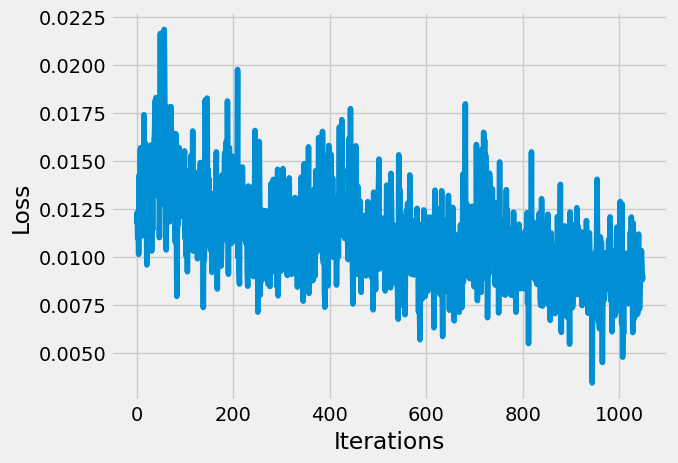

In [17]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

num_losses = []

for x in losses:
    num_losses.append(x.item())

plt.plot(num_losses)

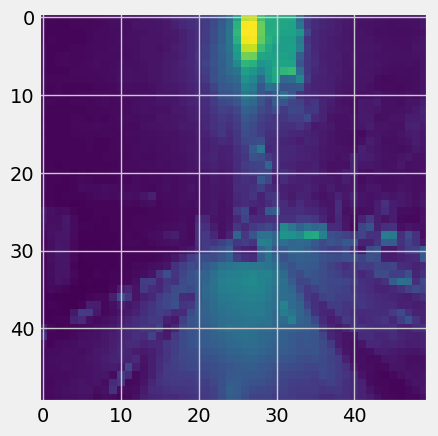

In [18]:
for i, item in enumerate(image):
  # Reshape the array for plotting
  item = item.reshape(-1, length, width)
  item = item.to("cpu").detach().numpy()
  plt.imshow(item[0])

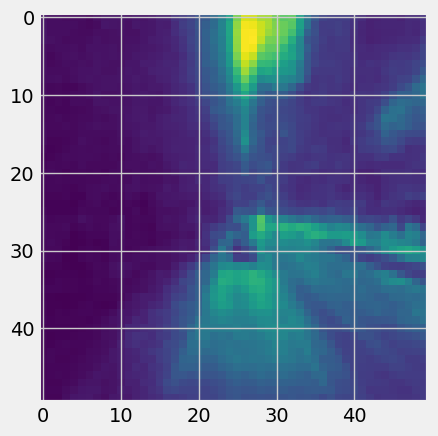

In [19]:
for i, item in enumerate(reconstructed):
  item = item.reshape(-1, length, width)
  item = item.to("cpu").detach().numpy()
  plt.imshow(item[0])